In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./dataset/resumo_anual_2019.csv', delimiter=";", encoding='latin-1')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37968 entries, 0 to 37967
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   EMPRESA (SIGLA)                    37968 non-null  object 
 1   EMPRESA (NOME)                     37968 non-null  object 
 2   EMPRESA (NACIONALIDADE)            37968 non-null  object 
 3   ANO                                37968 non-null  int64  
 4   MÊS                                37968 non-null  int64  
 5   AEROPORTO DE ORIGEM (SIGLA)        37959 non-null  object 
 6   AEROPORTO DE ORIGEM (NOME)         37959 non-null  object 
 7   AEROPORTO DE ORIGEM (UF)           31061 non-null  object 
 8   AEROPORTO DE ORIGEM (REGIÃO)       31064 non-null  object 
 9   AEROPORTO DE ORIGEM (PAÍS)         37959 non-null  object 
 10  AEROPORTO DE ORIGEM (CONTINENTE)   37959 non-null  object 
 11  AEROPORTO DE DESTINO (SIGLA)       37968 non-null  obj

In [4]:
df.head()

,EMPRESA (SIGLA),EMPRESA (NOME),EMPRESA (NACIONALIDADE),ANO,MÊS,AEROPORTO DE ORIGEM (SIGLA),AEROPORTO DE ORIGEM (NOME),AEROPORTO DE ORIGEM (UF),AEROPORTO DE ORIGEM (REGIÃO),AEROPORTO DE ORIGEM (PAÍS),...,COMBUSTÍVEL (LITROS),DISTÂNCIA VOADA (KM),DECOLAGENS,CARGA PAGA KM,CARGA GRATIS KM,CORREIO KM,ASSENTOS,PAYLOAD,HORAS VOADAS,BAGAGEM (KG)
0,AAF,AIGLE AZUR,ESTRANGEIRA,2019,1,LFPO,ORLY (NEAR PARIS),NaN,NaN,FRANÇA,...,NaN,149856.0,16.0,920725000.0,0.0,0.0,4592.0,770089.0,"144,86",NaN
1,AAF,AIGLE AZUR,ESTRANGEIRA,2019,1,SBKP,CAMPINAS,SP,SUDESTE,BRASIL,...,NaN,149856.0,16.0,263700000.0,25232000.0,0.0,4592.0,770089.0,"227,34",NaN
2,AAF,AIGLE AZUR,ESTRANGEIRA,2019,2,LFPO,ORLY (NEAR PARIS),NaN,NaN,FRANÇA,...,NaN,149856.0,16.0,617173000.0,0.0,0.0,4592.0,770089.0,"107,35",NaN
3,AAF,AIGLE AZUR,ESTRANGEIRA,2019,2,SBKP,CAMPINAS,SP,SUDESTE,BRASIL,...,NaN,149856.0,16.0,0.0,0.0,0.0,4592.0,770089.0,"267,29",NaN
4,AAF,AIGLE AZUR,ESTRANGEIRA,2019,3,LFPO,ORLY (NEAR PARIS),NaN,NaN,FRANÇA,...,NaN,159222.0,17.0,933032000.0,0.0,0.0,4879.0,1252270.0,"134,73",NaN


In [5]:
df.columns = ['EMPRESA_SIGLA','EMPRESA_NOME','EMPRESA_NACIONALIDADE','ANO','MES','AEROPORTO_DE_ORIGEM_SIGLA','AEROPORTO_DE_ORIGEM_NOME','AEROPORTO_DE_ORIGEM_UF','AEROPORTO_DE_ORIGEM_REGIAO','AEROPORTO_DE_ORIGEM_PAIS','AEROPORTO_DE_ORIGEM_CONTINENTE','AEROPORTO_DE_DESTINO_SIGLA','AEROPORTO_DE_DESTINO_NOME','AEROPORTO_DE_DESTINO_UF','AEROPORTO_DE_DESTINO_REGIAO','AEROPORTO_DE_DESTINO_PAIS','AEROPORTO_DE_DESTINO_CONTINENTE','NATUREZA','GRUPO_DE_VOO','PASSAGEIROS_PAGOS','PASSAGEIROS_GRATIS','CARGA_PAGA_KG','CARGA_GRATIS_KG','CORREIO_KG','ASK','RPK','ATK','RTK','COMBUSTIVEL_LITROS','DISTANCIA_VOADA_KM','DECOLAGENS','CARGA_PAGA_KM','CARGA_GRATIS_KM','CORREIO_KM','ASSENTOS','PAYLOAD','HORAS_VOADAS','BAGAGEM_KG']
df['HORAS_VOADAS'] = df['HORAS_VOADAS'].str.replace(',', '.').astype(float)

In [6]:
df = df[~(df[['EMPRESA_SIGLA','AEROPORTO_DE_ORIGEM_SIGLA','AEROPORTO_DE_DESTINO_SIGLA']].duplicated(keep=False)) & (df['AEROPORTO_DE_ORIGEM_SIGLA'] != df['AEROPORTO_DE_DESTINO_SIGLA'])]

In [7]:
columns = ['EMPRESA_SIGLA','EMPRESA_NOME','AEROPORTO_DE_ORIGEM_SIGLA','AEROPORTO_DE_ORIGEM_NOME','AEROPORTO_DE_ORIGEM_UF','AEROPORTO_DE_DESTINO_SIGLA','AEROPORTO_DE_DESTINO_NOME','AEROPORTO_DE_DESTINO_UF','DECOLAGENS','HORAS_VOADAS']

In [8]:
df = df[columns].dropna()

In [9]:
df_routes_by_airline = df[(df['EMPRESA_SIGLA'] == 'AZU') | (df['EMPRESA_SIGLA'] == 'TAM')]

In [10]:
nodes = set()
for i in df_routes_by_airline['AEROPORTO_DE_ORIGEM_SIGLA'].values:
    nodes.add(i)
for i in df_routes_by_airline['AEROPORTO_DE_DESTINO_SIGLA'].values:
    nodes.add(i)

nodes = sorted(nodes)

In [11]:
adjacency_list = {}

for n in nodes:
    adjacency_list[n] = []
    for d in df_routes_by_airline[df_routes_by_airline['AEROPORTO_DE_ORIGEM_SIGLA'] == n].values:
        adjacency_list[n].append(d[5])

In [12]:
#adjacency_list

In [13]:
def backtrace(parent, source, destiny):
    path = [destiny]
    while path[-1] != source:
        path.append(parent[path[-1]])
    path.reverse()
    path_map = {}
    for i,node in enumerate(path[:-1]):
        path_map[node] = path[i+1]
        
    return path_map

In [14]:
def bfs(graph, source, destiny):
    visited = {}
    queue = []
    traversal_tree = {}
    parent = {}
    
    queue.append(source)
    visited[source] = True
    
    while(queue):
        node = queue.pop(0)
        traversal_tree[node] = []
        
        if node == destiny:
            return backtrace(parent, source, destiny),traversal_tree
        
        for v in graph[node]:
            if v not in visited.keys():
                if node not in queue:
                    visited[v] = True
                    queue.append(v)
                    
                    traversal_tree[node].append(v)
                    parent[v] = node 

In [15]:
source = 'SBMS'
destiny = 'SBVH'
path,traversal_tree = bfs(adjacency_list, source, destiny)
print(source,destiny)

SBMS SBVH


In [16]:
path

{'SBMS': 'SBJP',
 'SBJP': 'SBSG',
 'SBSG': 'SBSV',
 'SBSV': 'SBGO',
 'SBGO': 'SBVH'}

In [17]:
#traversal_tree

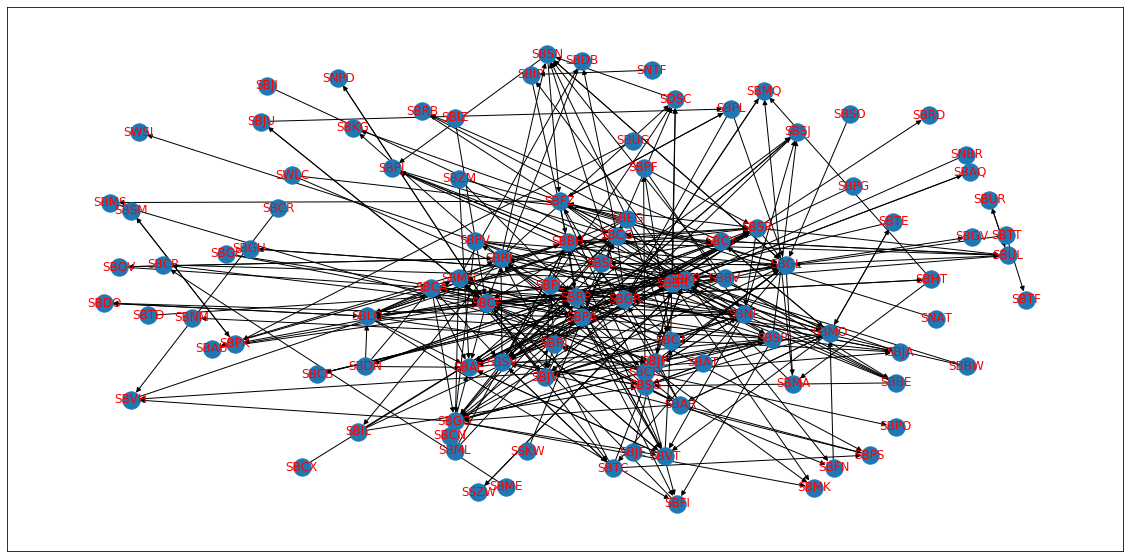

In [18]:
graph = nx.DiGraph()

graph.add_nodes_from(adjacency_list.keys())

for s in adjacency_list.keys():
    for d in adjacency_list[s]:
        graph.add_edge(s, d)
pos = nx.spring_layout(graph)

plt.figure(4,figsize=(20,10))

nx.draw_networkx(
    graph,
    pos=nx.spring_layout(graph,k=0.5,iterations=25),
    font_color='r'
)

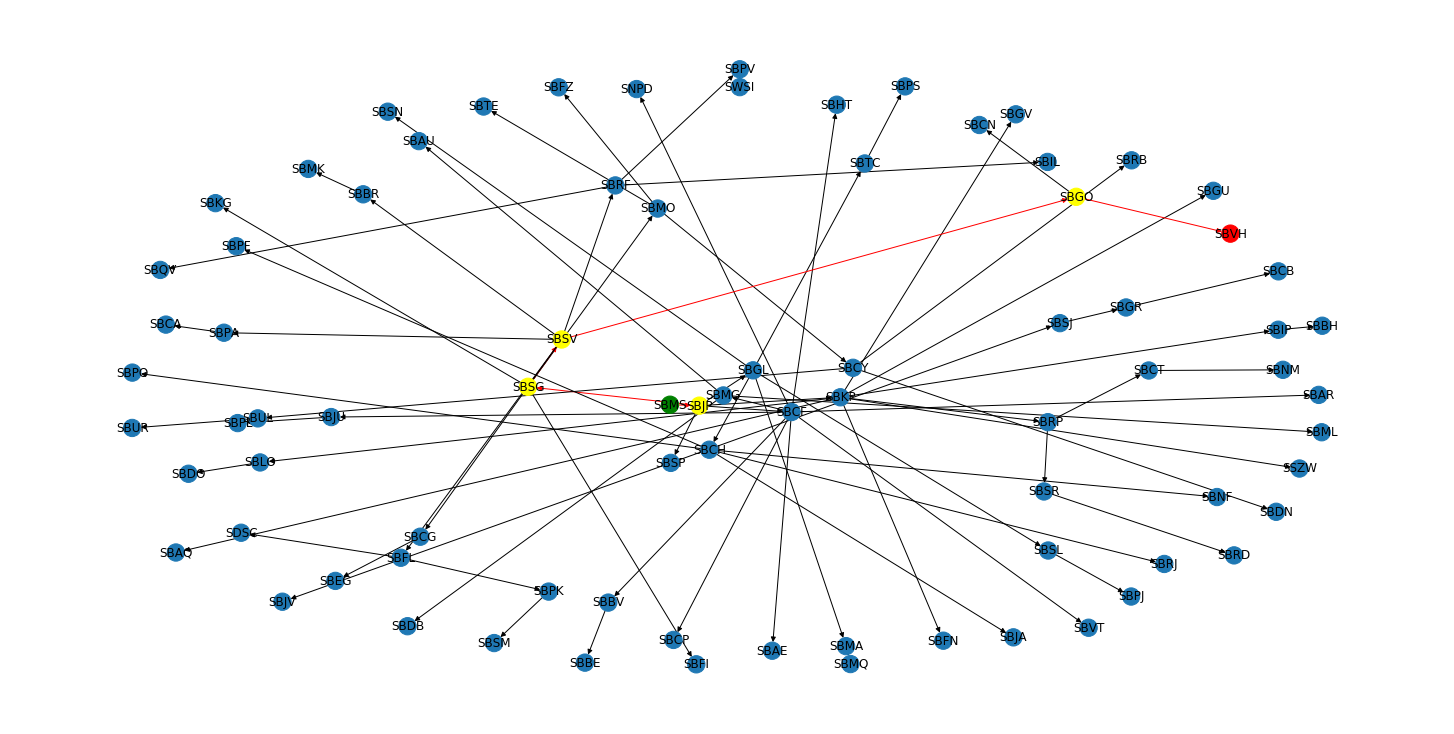

In [19]:
traversal_graph = nx.DiGraph()

traversal_graph.add_nodes_from(traversal_tree.keys())

edge_color = []

for s in traversal_tree.keys():
    for d in traversal_tree[s]:
        if s in path.keys() and path[s] == d:
            edge_color.append('r')
        else:
            edge_color.append('#000000')
        traversal_graph.add_edge(s, d)

color_map = []
for node in traversal_graph:
    if node == source:
        color_map.append('green')
    elif node == destiny: 
        color_map.append('red')  
    elif node in path.keys():
        color_map.append('yellow')  
    else:
        color_map.append('#1f78b4')
        
plt.figure(4,figsize=(20,10))   

nx.draw(traversal_graph, node_color=color_map, edge_color=edge_color, with_labels=True)

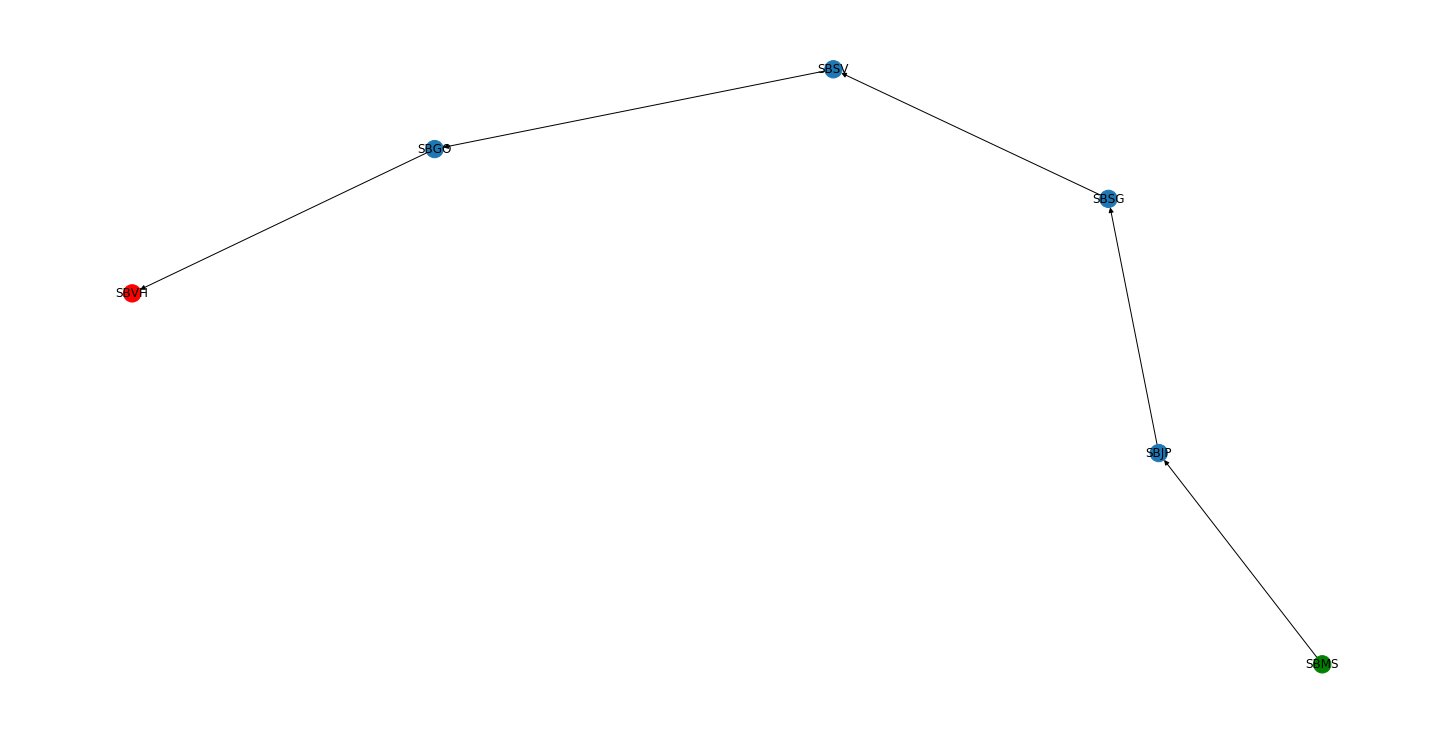

In [20]:
path_graph = nx.DiGraph()

path_graph.add_nodes_from(path.keys())

path_color_map = []
for node in path.keys():
    if node == source:
        path_color_map.append('green')
    else:
        path_color_map.append('#1f78b4')
        
path_color_map.append('red')  

for s in path.keys():
    path_graph.add_edge(s, path[s])

plt.figure(4,figsize=(20,10)) 
    
nx.draw(path_graph, node_color=path_color_map, with_labels=True)